In [180]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
bank_df = pd.read_csv(r'C:\Users\Ashish\Desktop\machine learning\bank.csv')
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                4521 non-null   int64 
 1   job                4521 non-null   object
 2   marital            4521 non-null   object
 3   education          4521 non-null   object
 4   default            4521 non-null   object
 5   balance            4521 non-null   int64 
 6   housing-loan       4521 non-null   object
 7   personal-loan      4521 non-null   object
 8   current-campaign   4521 non-null   int64 
 9   previous-campaign  4521 non-null   int64 
 10  subscribed         4521 non-null   object
dtypes: int64(4), object(7)
memory usage: 388.7+ KB


In [182]:
bank_df.subscribed.value_counts()

subscribed
no     4000
yes     521
Name: count, dtype: int64

In [183]:
# separate the case of yes-subscribe and no-subscribe
bank_subscribed_no= bank_df[bank_df.subscribed == 'no']
bank_subscribed_yes= bank_df[bank_df.subscribed == 'yes']

# upsample the yes-subscribe cases
df_minority_upsampled = resample(bank_subscribed_yes, replace = True, n_samples = 2000)

In [184]:
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])

In [185]:
from sklearn.utils import shuffle
new_bank_df = shuffle(new_bank_df)

In [186]:
#assigning list of all column names in the DataFrame
X_features = list(new_bank_df.columns)
#remove the responce variable from the list
X_features.remove('subscribed')
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [187]:
encoded_bank_df = pd.get_dummies(new_bank_df[X_features], drop_first = True)
X = encoded_bank_df

In [188]:
# Encoded the subcribed columns and assigning to Y
Y = new_bank_df.subscribed.map(lambda x: int(x == 'yes'))

In [189]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [190]:
logit = LogisticRegression()
logit.fit(train_X, train_Y)

C:\Users\Ashish\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [191]:
pred_y = logit.predict(test_X)

In [192]:
# defining the matrix to draw the confusion matrix from actual and predicting class labels
def draw_cm(actual, predicted):
    # Invoking confusion_matrix from metric packege. the matrix 
    #will be oriented as [1,0] i.e. the classes with label 1 will be
    #represented by the first row and 0 as second row
    cm = metrics.confusion_matrix(actual, predicted, labels=[1,0])
    sns.heatmap(cm, annot = True, fmt = '.2f',
                xticklabels = ["Subscribed", "Not subscribed"],
                yticklabels = ["Subscribed", "Not subscribed "])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

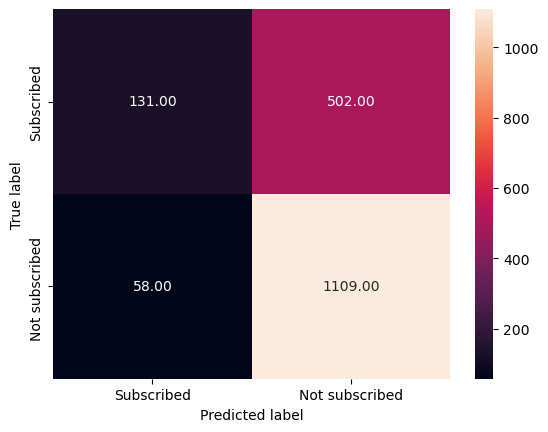

In [193]:
cm= draw_cm(test_Y,pred_y)

In [194]:
print(metrics.classification_report(test_Y, pred_y))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1167
           1       0.69      0.21      0.32       633

    accuracy                           0.69      1800
   macro avg       0.69      0.58      0.56      1800
weighted avg       0.69      0.69      0.63      1800



In [195]:
predict_proba_df = pd.DataFrame(logit.predict_proba(test_X))
predict_proba_df.head()

,0,1
0,0.652657,0.347343
1,0.645101,0.354899
2,0.580062,0.419938
3,0.655662,0.344338
4,0.770157,0.229843


In [196]:
# inititalize the dataframe with actual class labels
test_result_df = pd.DataFrame({'actual' : test_Y})
test_result_df = test_result_df.reset_index()
#assigning the probability values for class label 1
test_result_df['chd_1']= predict_proba_df.iloc[:, 1:2]

In [197]:
test_result_df.head()

,index,actual,chd_1
0,2236,0,0.347343
1,1325,0,0.354899
2,619,1,0.419938
3,4112,0,0.344338
4,784,0,0.229843


In [198]:
#passing actual class labels and predicted probability values
#to compute ROC AUC score
auc_score = metrics.roc_auc_score(test_result_df.actual, test_result_df.chd_1)
round( float(auc_score), 2)

0.69

In [199]:
#the maethod takes the following three parameters
## model : the classification model
## test_x : X features of the test set
## test_y: actual labels of the test set
## returns
## - ROC Auc score
## FPR and TPR for different threshold values
def draw_roc_curve(model, test_X, test_Y):
    ## creating and initialising a result dataframe with actual labels
    test_result_df = pd.DataFrame({'actual' : test_Y})
    test_result_df = test_result_df.reset_index()
    # predict the probabilities on the test set
    predict_proba_df = pd.DataFrame(model.predict_proba(test_X))
    ## selecting the probabilities that test example belong to class 1
    test_result_df['chd_1'] = predict_proba_df.iloc[:, 1:2]
    ## invoke the roc curve to return fpr, tpr and threshold values
    ## threshold vlaues contain values 0.0 to 1.0 
    fpr, tpr, thresholds = metrics.roc_curve(test_result_df.actual, test_result_df.chd_1, drop_intermediate=False)
    ## getting roc auc score by invoking metrics.roce_auc_score method
    auc_score = metrics.roc_auc_score(test_result_df.actual, test_result_df.chd_1)
    ## setting the size of the plot 
    plt.figure(figsize = (8,6))
    plt.plot(fpr, tpr, label = 'ROC curve(area = %a.2f)' % auc_score)
    plt.plot ([0,1],[0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate or [1- true negative rate]')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")
    plt.show()
    return auc_score, fpr, tpr, thresholds

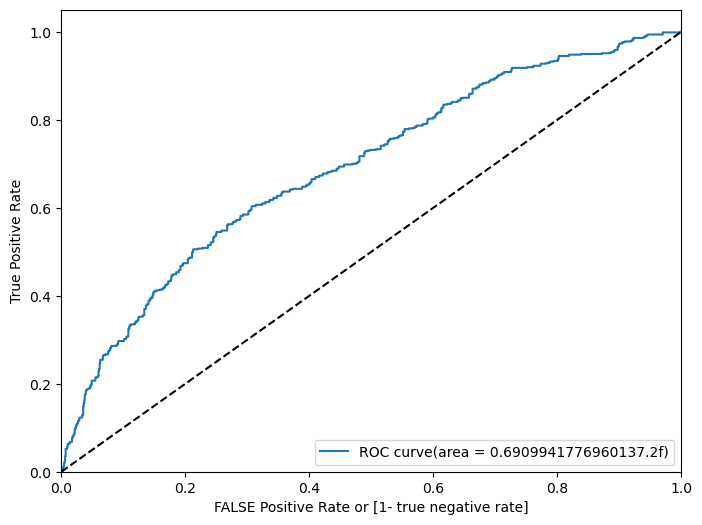

In [200]:
_, _, _, _ = draw_roc_curve(logit, test_X, test_Y)

In [201]:
from sklearn.neighbors import KNeighborsClassifier

In [202]:
# initializing the classifire
knn_cif = KNeighborsClassifier()
## fititing the model with the training set
knn_cif.fit(train_X, train_Y)

KNeighborsClassifier()

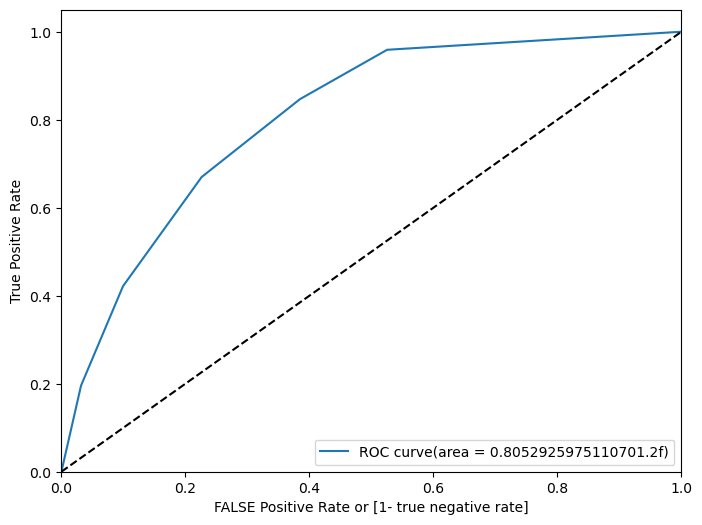

In [203]:
_, _, _, _ = draw_roc_curve(knn_cif, test_X, test_Y)

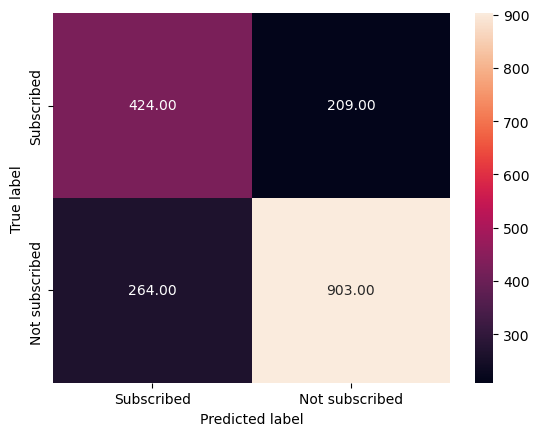

In [204]:
#predicting on test set
pred_y = knn_cif.predict(test_X)
## drawing the confusion matrix
draw_cm(test_Y, pred_y)

In [205]:
print(metrics.classification_report(test_Y, pred_y))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1167
           1       0.62      0.67      0.64       633

    accuracy                           0.74      1800
   macro avg       0.71      0.72      0.72      1800
weighted avg       0.74      0.74      0.74      1800



In [206]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'n_neighbors' : range(5,10), 'metric': ['canberra', 'euclidean', 'minkowski']}]
## congifuring grid search 
cif = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=  10, scoring = 'roc_auc')
## fit the search with training set
cif.fit(train_X, train_Y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['canberra', 'euclidean', 'minkowski'],
                          'n_neighbors': range(5, 10)}],
             scoring='roc_auc')

In [207]:
cif.best_score_

0.8193515959611336

In [208]:
cif.best_params_

{'metric': 'canberra', 'n_neighbors': 5}

In [209]:
cif.cv_results_

{'mean_fit_time': array([0.00674984, 0.00781155, 0.        , 0.00312378, 0.0046876 ,
        0.00624959, 0.00625379, 0.00312459, 0.00312488, 0.00468659,
        0.00312316, 0.00468686, 0.00781169, 0.00624878, 0.00312459]),
 'std_fit_time': array([0.00738821, 0.00781155, 0.        , 0.00624757, 0.00716042,
        0.00765416, 0.0076593 , 0.00624919, 0.00624976, 0.00715889,
        0.00624633, 0.00715929, 0.00781169, 0.00765317, 0.00624919]),
 'mean_score_time': array([0.1185499 , 0.12030361, 0.10468249, 0.1000947 , 0.09686506,
        0.05312114, 0.06405466, 0.06093547, 0.06093123, 0.06093321,
        0.06249731, 0.05624733, 0.05312035, 0.05312297, 0.05937145]),
 'std_score_time': array([0.00789538, 0.01570115, 0.01000292, 0.00757408, 0.00624371,
        0.00765762, 0.01094241, 0.00841674, 0.01094281, 0.00468409,
        0.00698937, 0.00765403, 0.00765417, 0.00765471, 0.00937366]),
 'param_metric': masked_array(data=['canberra', 'canberra', 'canberra', 'canberra',
                    'c

In [210]:
from sklearn.ensemble import RandomForestClassifier

In [211]:
radm_cif = RandomForestClassifier(max_depth = 10, n_estimators = 10)
radm_cif.fit(train_X, train_Y)

RandomForestClassifier(max_depth=10, n_estimators=10)

In [212]:
tuned_parameters = [{'max_depth' : [10,15], 'n_estimators' : [10,20], 'max_features' : ['sqrt', 0.2]}]
radm_cif = RandomForestClassifier()
cif = GridSearchCV(radm_cif,tuned_parameters, cv=5, scoring= 'roc_auc')
cif.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 15], 'max_features': ['sqrt', 0.2],
                          'n_estimators': [10, 20]}],
             scoring='roc_auc')

In [213]:
cif.best_score_

0.9264831242526587

In [214]:
cif.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 20}

In [215]:
radm_cif = RandomForestClassifier(max_depth=15, n_estimators=20, max_features='sqrt')
radm_cif.fit(train_X, train_Y)

RandomForestClassifier(max_depth=15, n_estimators=20)

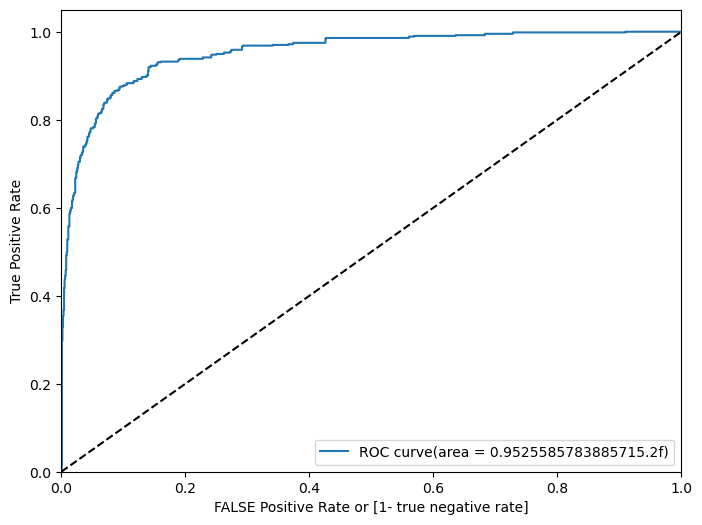

In [216]:
_, _, _, _ = draw_roc_curve(cif, test_X, test_Y)

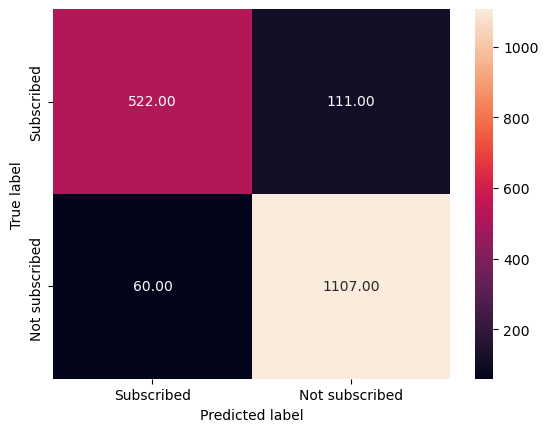

In [217]:
pred_y = radm_cif.predict(test_X)
draw_cm(test_Y, pred_y)

In [218]:
print(metrics.classification_report(test_Y, pred_y))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1167
           1       0.90      0.82      0.86       633

    accuracy                           0.91      1800
   macro avg       0.90      0.89      0.89      1800
weighted avg       0.90      0.91      0.90      1800



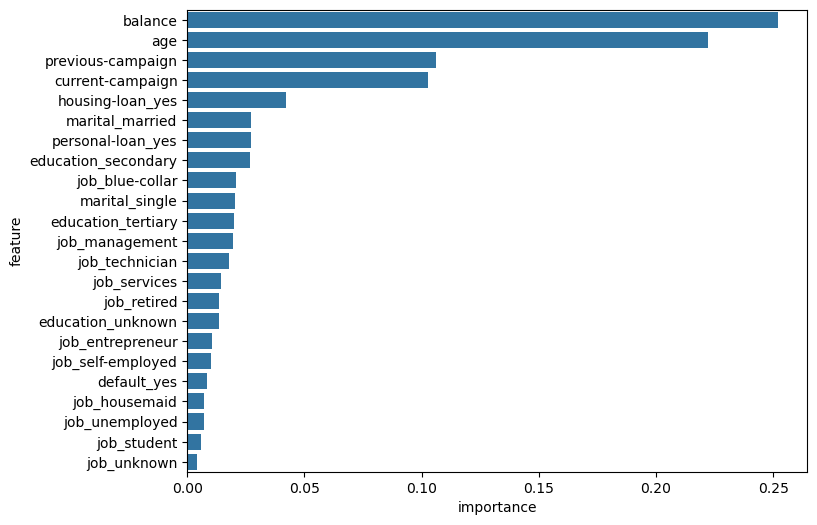

In [219]:
import numpy as np
#create a dataframe to store the features and their corresponding importance
feature_rank = pd.DataFrame({'feature' : train_X.columns, 'importance' : radm_cif.feature_importances_})
# sorting the feature based on their importance with most
# important features at top
feature_rank = feature_rank.sort_values('importance', ascending = False)
plt.figure(figsize = (8,6))
#plot the values
sns.barplot(y = 'feature', x = 'importance', data = feature_rank);

In [220]:
feature_rank['cumsum'] = feature_rank.importance.cumsum()*100
feature_rank.head(10)

,feature,importance,cumsum
1,balance,0.251902,25.190191
0,age,0.221996,47.389744
3,previous-campaign,0.106228,58.012495
2,current-campaign,0.102866,68.299077
21,housing-loan_yes,0.042185,72.517561
15,marital_married,0.027334,75.250966
22,personal-loan_yes,0.027001,77.951017
17,education_secondary,0.026793,80.630289
4,job_blue-collar,0.020750,82.705314
16,marital_single,0.020505,84.755824


In [221]:
from sklearn.ensemble import AdaBoostClassifier
# initialise the logistic regression to use as base classifier
log_reg = LogisticRegression()
# inititaliseing adaboost classifier
ada_clf = AdaBoostClassifier(log_reg, n_estimators=50)
#fitting adaboost model to training set
ada_clf.fit(train_X, train_Y)

C:\Users\Ashish\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ashish\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ashish\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sca

AdaBoostClassifier(estimator=LogisticRegression())

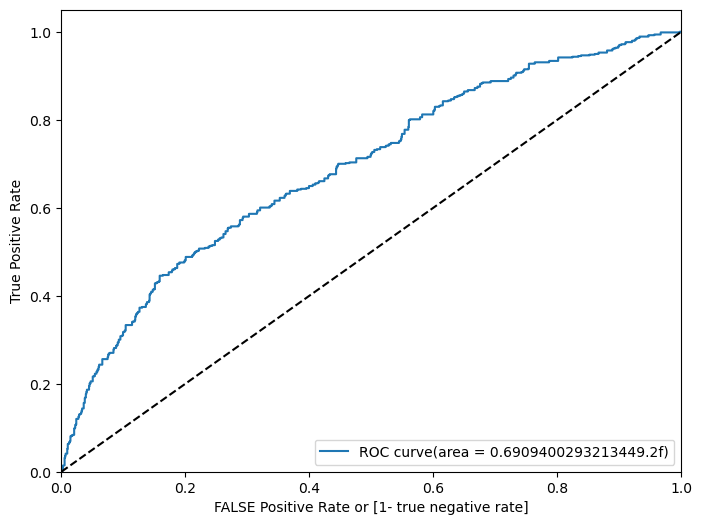

In [222]:
_, _, _, _ = draw_roc_curve(ada_clf, test_X, test_Y)

In [223]:
from sklearn.ensemble import GradientBoostingClassifier
gboost_clf = GradientBoostingClassifier(n_estimators=500, max_depth=10)
gboost_clf.fit(train_X, train_Y)

GradientBoostingClassifier(max_depth=10, n_estimators=500)

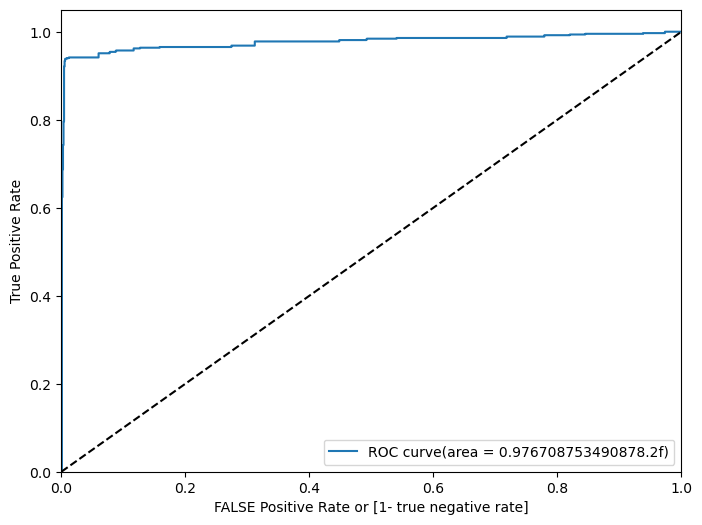

In [224]:
_, _, _, _ = draw_roc_curve(gboost_clf, test_X, test_Y)

In [225]:
from sklearn.model_selection import cross_val_score
gboost_clf = GradientBoostingClassifier(n_estimators=500, max_depth=10)
cv_scores = cross_val_score(gboost_clf, train_X, train_Y, cv= 10, scoring = 'roc_auc')

In [226]:
print(cv_scores)
print("Mean Accuracy :" , np.mean(cv_scores), "with standard deviation of:", np.std(cv_scores))

[0.94970468 0.96200769 0.95597225 0.98207423 0.96876531 0.97178303
 0.97914678 0.96688587 0.96367543 0.96442626]
Mean Accuracy : 0.9664441545824369 with standard deviation of: 0.009279189364835011


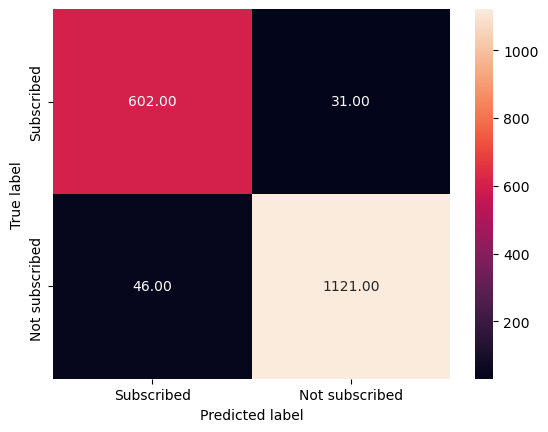

In [227]:
gboost_clf.fit(train_X, train_Y)
pred_y = gboost_clf.predict(test_X)
draw_cm(test_Y, pred_y)

In [228]:
print(metrics.classification_report(test_Y, pred_y))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1167
           1       0.93      0.95      0.94       633

    accuracy                           0.96      1800
   macro avg       0.95      0.96      0.95      1800
weighted avg       0.96      0.96      0.96      1800



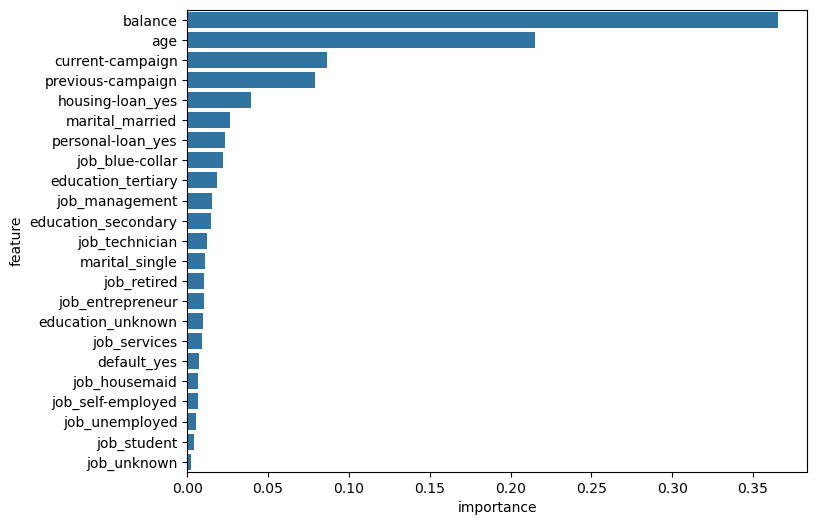

In [229]:
feature_rank = pd.DataFrame({'feature': train_X.columns, 'importance': gboost_clf.feature_importances_})
feature_rank = feature_rank.sort_values('importance', ascending = False)
plt.figure(figsize = (8,6))
sns.barplot(y = 'feature', x = 'importance', data = feature_rank);